In [1]:
from datetime import datetime

import incense
import matplotlib.pyplot as plt
import numpy as np
from incense import ExperimentLoader


In [2]:
loader = ExperimentLoader(db_name="sacred")


In [3]:
def parse_params(s: str) -> dict:
    """Parse a string of space-separated key=value pairs into a dictionary.

    Example:
        >>> parse_params("a=10 b=1e-4 c=bab | some comment # whatever else")
        {'a': 10, 'b': 0.0001, 'c': 'bab'}
    """
    result = {}
    pairs = s.strip().split()

    for pair in pairs:
        try:
            key, value = pair.split("=")
        except Exception:
            continue
        try:
            value = float(value)
            if value.is_integer():
                value = int(value)
        except ValueError:
            pass
        result[key] = value

    return result


print(parse_params("a=10 b=1e-4 c=bab | some comment # whatever else"))


{'a': 10, 'b': 0.0001, 'c': 'bab'}


In [4]:
from collections import defaultdict
from pprint import pprint

lists = defaultdict(list)

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if "random-1" not in notes:
        continue
    print(notes)
    try:
        params = parse_params(notes)
        epochs = params["epochs"]
        lr = params["lr"]
        losses = exp.metrics["loss"][-3:]
        avg = sum(losses) / len(losses)
        lists[(epochs, lr)].append(avg)
    except Exception:
        continue


In [5]:
from collections import defaultdict
from pprint import pprint

lists = defaultdict(list)
name = "slope"

for exp in loader.find_all():
    notes = exp.meta["comment"]
    if name not in notes and "fixed-steps" not in notes:
        continue

    try:
        params = parse_params(notes)
        step = params["step"]
        w = params.get("w", None)
        if params["k"] == "AR":
            w = 1
        elif params["k"] == "D":
            w = 100
        last_q50 = exp.metrics["q50"][-3:]
        avg = sum(last_q50) / len(last_q50)
        lists[(step, w)].append(avg)
    except Exception:
        continue


In [6]:
lists


defaultdict(list,
            {(4, 1): [0.4911794265111287,
              0.4911794265111287,
              0.4911794265111287,
              0.4911794265111287,
              0.4911794265111287,
              3.1382877826690674],
             (4, 2): [0.37404253085454303,
              0.37404253085454303,
              0.37404253085454303,
              0.37404253085454303,
              0.37404253085454303,
              4.702984809875488],
             (4, 4): [0.2593304365873337,
              0.2593304365873337,
              0.2593304365873337,
              0.2593304365873337,
              0.2593304365873337,
              3.716294765472412],
             (4, 8): [0.14303994178771973,
              0.14303994178771973,
              0.14303994178771973,
              0.14303994178771973,
              0.14303994178771973],
             (4, 32): [0.3340282738208771,
              0.3340282738208771,
              0.3340282738208771,
              0.3340282738208771,
           

/Users/mike/Desktop/gud/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


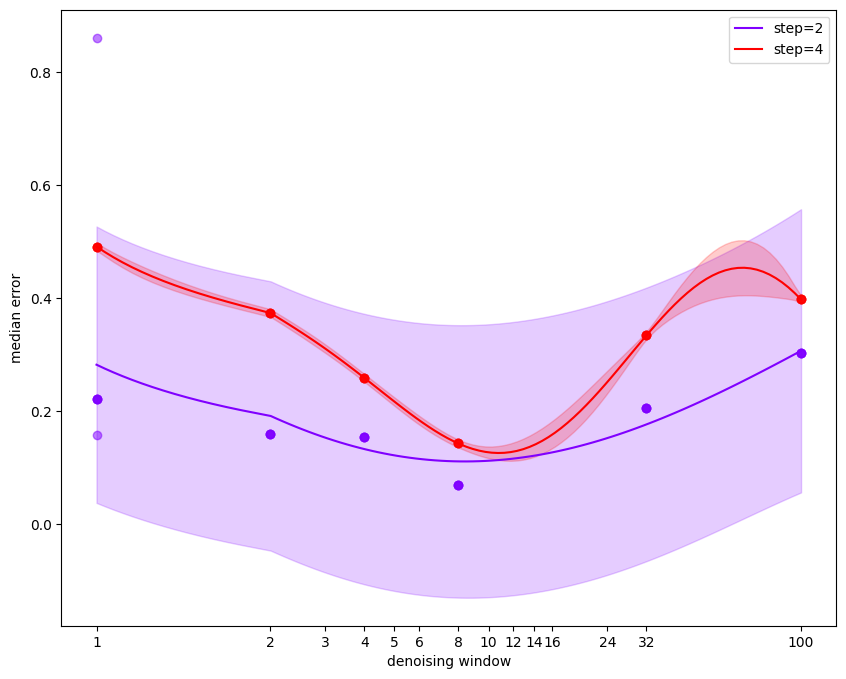

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

plt.figure(figsize=(10, 8))
plt.xscale("symlog")
ws = sorted(list(set([w for (step, w) in lists])))
steps = sorted(list(set([step for (step, w) in lists])))
colors = plt.cm.rainbow(np.linspace(0, 1, len(steps)))

for step, color in zip(steps, colors):
    # Collect data points
    X, y = [], []
    for w in ws:
        cur = lists[(step, w)]
        cur = [x for x in cur if x < 2]
        if len(cur) > 0:
            X.extend([w] * len(cur))
            y.extend(cur)
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)

    if len(X) == 0:
        continue

    # Fit GP
    kernel = RBF(length_scale_bounds=(0.5, 5.0)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.log10(X), y)

    # Predict
    X_test = np.logspace(np.log10(min(ws)), np.log10(max(ws)), 100).reshape(-1, 1)
    y_pred, y_std = gp.predict(np.log10(X_test), return_std=True)

    # Plot
    plt.plot(X_test, y_pred, "-", label=f"step={step}", color=color)
    plt.fill_between(
        X_test.ravel(), y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.2, color=color
    )
    plt.plot(X, y, "o", alpha=0.5, color=color)

plt.xticks(ws, [str(w) for w in ws])
plt.xlabel("denoising window")
plt.ylabel("median error")
plt.legend()
plt.show()
